In [1]:
%matplotlib inline

import gc
import glob
import itertools
import matplotlib
from matplotlib import pyplot
import numpy
import os
import pandas
import pysam
import seaborn
import sys

pandas.options.display.max_columns = None
pandas.options.display.max_rows = None

matplotlib.rcParams['figure.dpi'] = 200
matplotlib.rcParams['agg.path.chunksize'] = 10000

print(f'Package versions:\nPython {sys.version}, matplotlib {matplotlib.__version__}, '
      f'numpy {numpy.__version__}, pandas {pandas.__version__}, '
      f'pysam {pysam.__version__}, seaborn {seaborn.__version__}')

Package versions:
Python 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 06:08:53) 
[GCC 9.4.0], matplotlib 3.4.2, numpy 1.21.0, pandas 1.1.5, pysam 0.16.0.1, seaborn 0.11.1


In [2]:
def rev_comp(dna_seq):
    bp_map = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
    return ''.join([bp_map[elt] for elt in list(dna_seq[::-1])])

In [3]:
r1_seqs = dict(
    WT =  'GAACTCTCTGTGCTAGTAACCACGTTCTCCTGATCAAATATCACTCTCCT',
    MUT = 'GAACTCTCTGTGCTAGTAACCACGTTCTCCTAATCAAATATCACTCTCCT',
)
r1_seqs_r = {v:k for k,v in r1_seqs.items()}

In [4]:
def allow_substitutions(bc_list, num_subs=2, immutable_bases=[]):
    immutable_bases = set(immutable_bases)
    bc_map = {}
    bc_len = len(bc_list[0])
    if bc_len < num_subs:
        raise Exception('Number of substitutions allowed ({!s}) must be less '
                        'than or equal to the barcode length ({!s})'.format(num_subs, bc_len))
    sub_idx = list(itertools.combinations(numpy.arange(bc_len), num_subs))
    possible_edits = list(set(itertools.permutations(['A', 'C', 'G', 'T', 'N'], num_subs)))
    for bc_elt in bc_list:
        bc_elt_list = list(bc_elt)
        for edit_idx, edit_bases in itertools.product(sub_idx, possible_edits):
            bc_tmp = list(bc_elt_list)
            for idx, base in zip(edit_idx, edit_bases):
                if idx in immutable_bases:
                    continue
                try:
                    bc_tmp[idx] = base
                except:
                    raise Exception(bc_tmp, edit_idx, edit_bases, idx, base)
            bc_map[''.join(bc_tmp)] = bc_elt
    return bc_map

In [5]:
r1_ed1_map = allow_substitutions(list(r1_seqs.values()), 1, immutable_bases=[31])

## Get data

In [6]:
sample_info = pandas.read_csv('./sample_info.csv', index_col=0)
print(sample_info.shape)
sample_info.head()

(27, 4)


,Number,Replicate,Treatment,Fraction
Library ID,,,,
F1,37,1,Glu,Right tail
F2,38,2,Glu,Right tail
F3,39,3,Glu,Right tail
F4,40,1,Gal,Right tail
F5,41,2,Gal,Right tail


In [7]:
fastq_paths = sorted([elt for elt in glob.glob('./fastq/*R1_001.fastq.gz') if 'Undetermined' not in elt])
print(len(fastq_paths))
print('\n'.join(fastq_paths))

27
./fastq/F10_S7_L001_R1_001.fastq.gz
./fastq/F11_S8_L001_R1_001.fastq.gz
./fastq/F12_S9_L001_R1_001.fastq.gz
./fastq/F1_S1_L001_R1_001.fastq.gz
./fastq/F2_S2_L001_R1_001.fastq.gz
./fastq/F3_S3_L001_R1_001.fastq.gz
./fastq/F4_S4_L001_R1_001.fastq.gz
./fastq/F5_S5_L001_R1_001.fastq.gz
./fastq/F6_S6_L001_R1_001.fastq.gz
./fastq/G10_S19_L001_R1_001.fastq.gz
./fastq/G11_S20_L001_R1_001.fastq.gz
./fastq/G12_S21_L001_R1_001.fastq.gz
./fastq/G1_S10_L001_R1_001.fastq.gz
./fastq/G2_S11_L001_R1_001.fastq.gz
./fastq/G3_S12_L001_R1_001.fastq.gz
./fastq/G4_S13_L001_R1_001.fastq.gz
./fastq/G5_S14_L001_R1_001.fastq.gz
./fastq/G6_S15_L001_R1_001.fastq.gz
./fastq/G7_S16_L001_R1_001.fastq.gz
./fastq/G8_S17_L001_R1_001.fastq.gz
./fastq/G9_S18_L001_R1_001.fastq.gz
./fastq/H1_S22_L001_R1_001.fastq.gz
./fastq/H2_S23_L001_R1_001.fastq.gz
./fastq/H3_S24_L001_R1_001.fastq.gz
./fastq/H4_S25_L001_R1_001.fastq.gz
./fastq/H5_S26_L001_R1_001.fastq.gz
./fastq/H6_S27_L001_R1_001.fastq.gz


In [8]:
sample_stats = {'sample_id':[],
                'read_count':[],
                'wt_count':[],
                'mut_count':[],
                'unknown_count':[]}

record_count = 0
read_idx = {}
r1_seq_len_set = set([len(elt) for elt in r1_seqs.values()])
for fastq_path in fastq_paths:
    sample_id = os.path.basename(fastq_path).split('_')[0]
    read_count = 0
    wt_count = 0
    mut_count = 0
    unknown_count = 0
    with pysam.FastqFile(fastq_path) as fq1_in:
        for r1 in fq1_in:
            read_count += 1
            if record_count and not record_count%5e6:
                print('Processed {!s} reads.'.format(record_count))
            record_count += 1

            #tally read1 matches
            for seq_len, offset in itertools.product(r1_seq_len_set, range(8)):
                try:
                    r1_seq_corr = r1_ed1_map[r1.sequence[offset:offset+seq_len]]
#                    print(offset, r1.sequence)
#                    break
                except KeyError:
                    pass
                else:
                    if r1_seqs_r[r1_seq_corr] == 'WT':
                        wt_count += 1
                    elif r1_seqs_r[r1_seq_corr] == 'MUT':
                        mut_count += 1
                    break
            else:
                unknown_count += 1
#            break
        sample_stats['sample_id'].append(sample_id)
        sample_stats['read_count'].append(read_count)
        sample_stats['wt_count'].append(wt_count)
        sample_stats['mut_count'].append(mut_count)
        sample_stats['unknown_count'].append(unknown_count)
#        break
else:
    print(f'Finished processing {record_count} total reads.')

sample_stats = pandas.DataFrame(sample_stats)
gc.collect()
print(sample_stats.shape)
sample_stats.head()

Processed 5000000 reads.
Finished processing 5054277 total reads.
(27, 5)


,sample_id,read_count,wt_count,mut_count,unknown_count
0,F10,155144,124562,29548,1034
1,F11,161535,128054,32378,1103
2,F12,175575,140411,34004,1160
3,F1,116071,85590,29298,1183
4,F2,209783,157647,50847,1289


In [9]:
xorder = sorted(sample_stats['sample_id'].values, key=lambda x:(x[0], int(x[1:])))
sample_stats = sample_stats.set_index('sample_id').loc[xorder].reset_index()
sample_stats.head()

,sample_id,read_count,wt_count,mut_count,unknown_count
0,F1,116071,85590,29298,1183
1,F2,209783,157647,50847,1289
2,F3,170132,126710,42423,999
3,F4,106238,78595,26976,667
4,F5,201588,150376,50025,1187


In [10]:
sample_info = sample_info.join(sample_stats.set_index('sample_id')).reset_index()
print(sample_info.shape)
sample_info.head()

(27, 9)


,Library ID,Number,Replicate,Treatment,Fraction,read_count,wt_count,mut_count,unknown_count
0,F1,37,1,Glu,Right tail,116071,85590,29298,1183
1,F2,38,2,Glu,Right tail,209783,157647,50847,1289
2,F3,39,3,Glu,Right tail,170132,126710,42423,999
3,F4,40,1,Gal,Right tail,106238,78595,26976,667
4,F5,41,2,Gal,Right tail,201588,150376,50025,1187


In [11]:
sample_info['sample_name'] = (sample_info['Treatment'] + '_' + sample_info['Fraction'] 
                              + '_rep' + sample_info['Replicate'].astype(str))

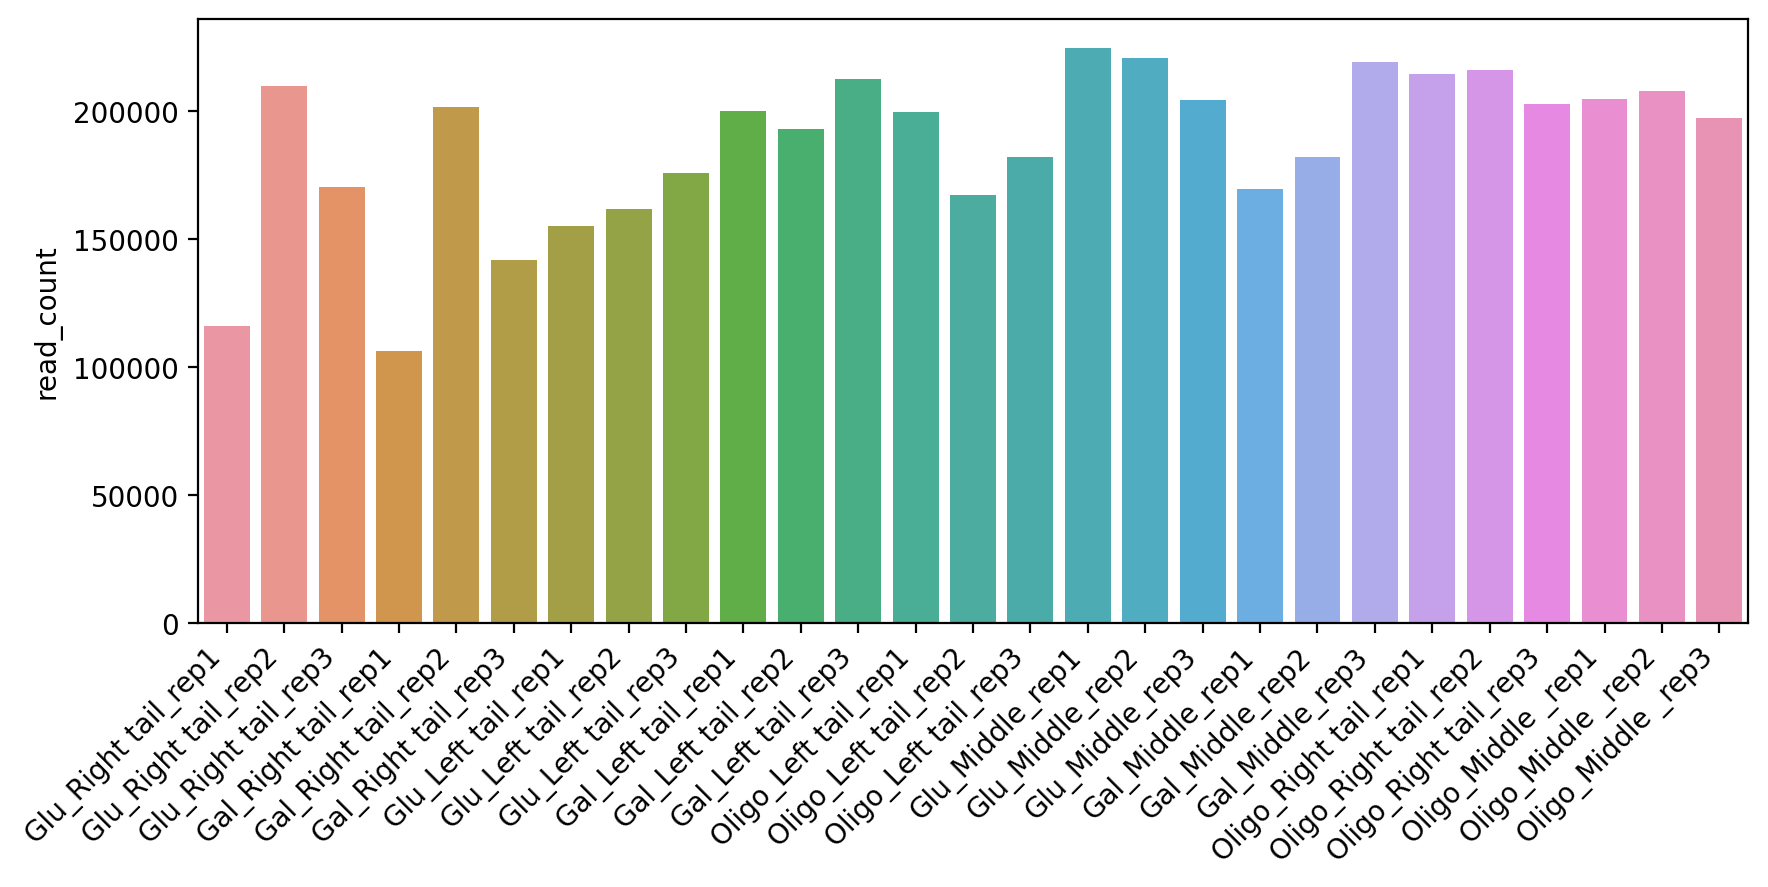

In [12]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
seaborn.barplot(data=sample_info, x='sample_name', y='read_count', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_xlabel('')
fig.show()

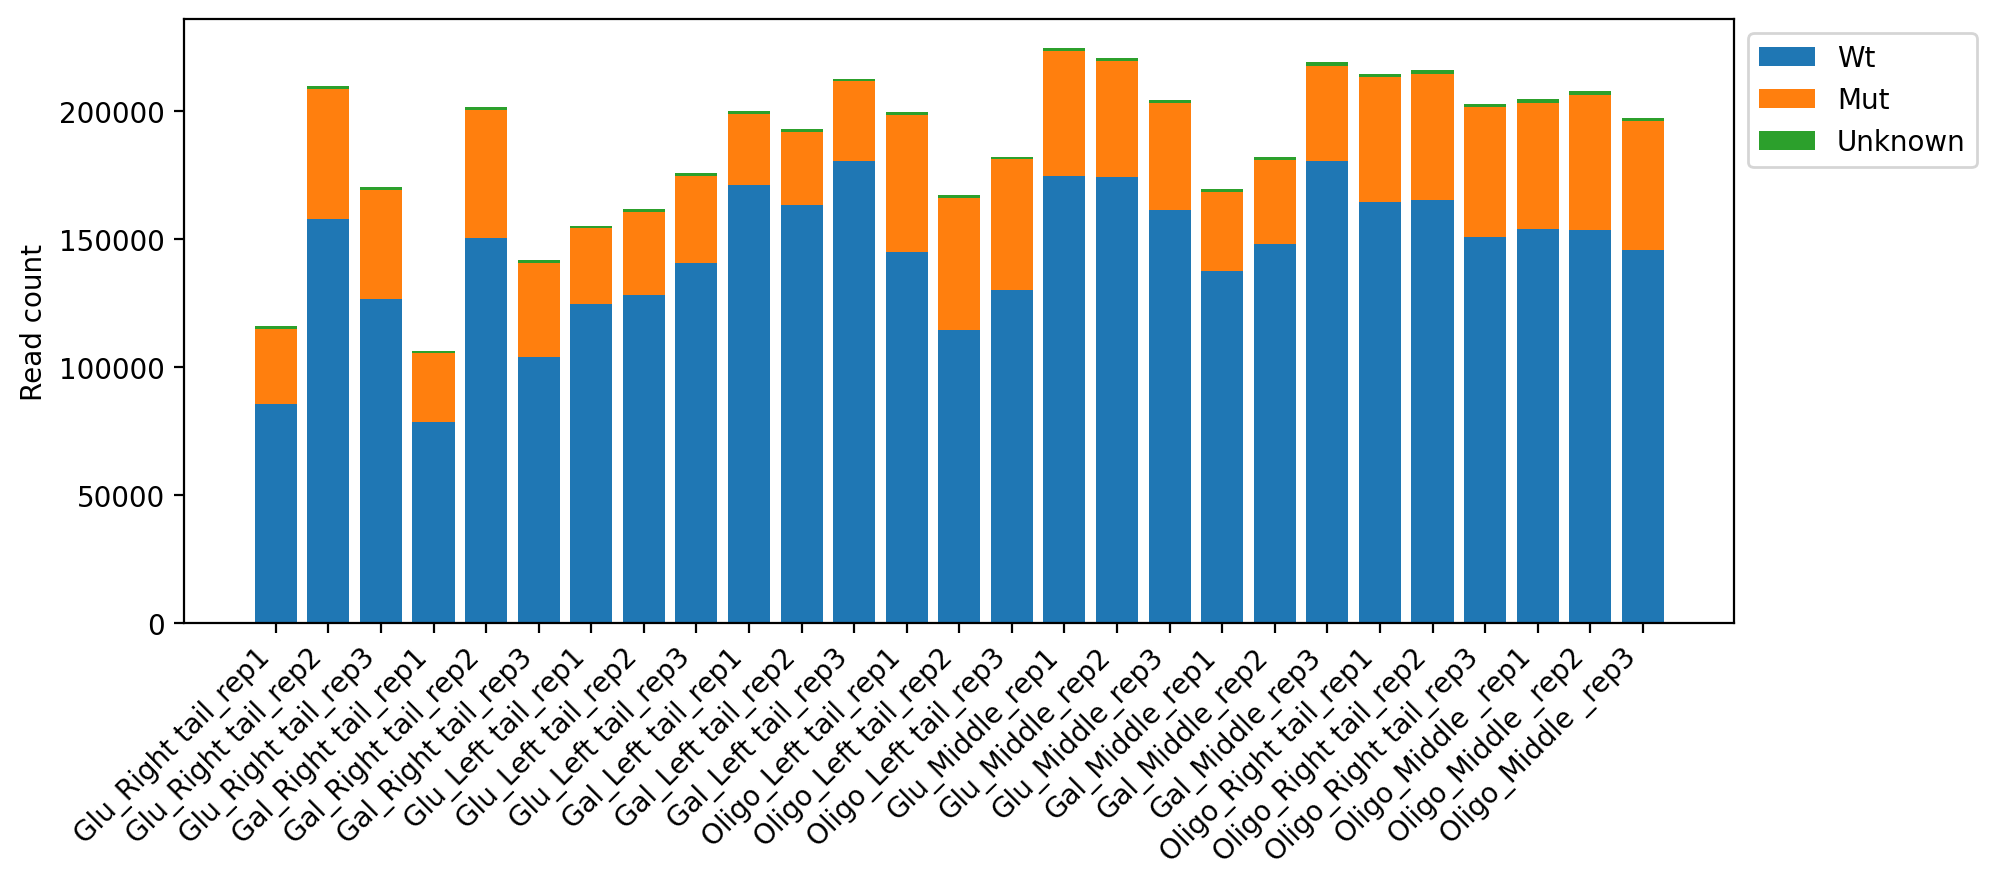

In [13]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
xticks = numpy.arange(sample_info.shape[0])
bottom = numpy.zeros(sample_info.shape[0])
for data_col in ['wt_count', 'mut_count', 'unknown_count']:
    axes.bar(x=xticks, height=sample_info[data_col].values, bottom=bottom, label=data_col.split('_')[0].capitalize())
    bottom += sample_info[data_col].values
axes.set_xticks(xticks)
axes.set_xticklabels(sample_info['sample_name'].values, ha='right', rotation=45)
axes.set_xlabel('')
axes.set_ylabel('Read count')
axes.legend(loc='upper left', bbox_to_anchor=[1,1])
fig.show()

In [14]:
sample_info['mut_het'] = sample_info['mut_count']/(sample_info['wt_count'] + sample_info['mut_count'])
sample_info.head()

,Library ID,Number,Replicate,Treatment,Fraction,read_count,wt_count,mut_count,unknown_count,sample_name,mut_het
0,F1,37,1,Glu,Right tail,116071,85590,29298,1183,Glu_Right tail_rep1,0.255014
1,F2,38,2,Glu,Right tail,209783,157647,50847,1289,Glu_Right tail_rep2,0.243878
2,F3,39,3,Glu,Right tail,170132,126710,42423,999,Glu_Right tail_rep3,0.250826
3,F4,40,1,Gal,Right tail,106238,78595,26976,667,Gal_Right tail_rep1,0.255525
4,F5,41,2,Gal,Right tail,201588,150376,50025,1187,Gal_Right tail_rep2,0.249625


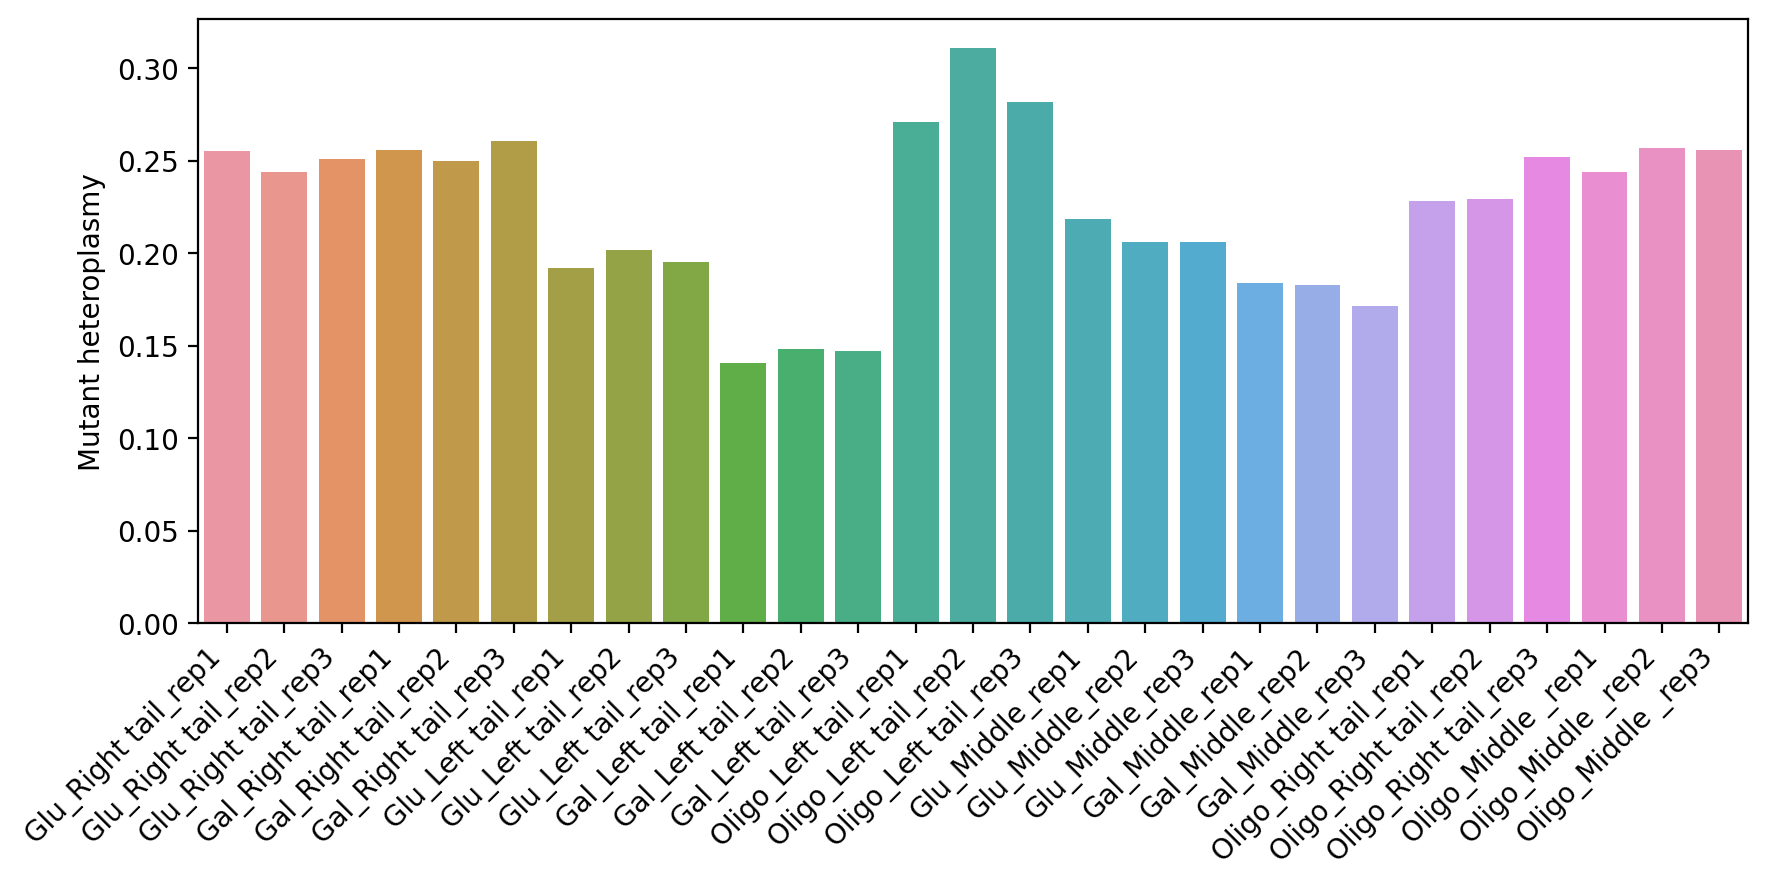

In [15]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
seaborn.barplot(data=sample_info, x='sample_name', y='mut_het', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_xlabel('')
axes.set_ylabel('Mutant heteroplasmy')
fig.show()

In [16]:
sample_info['sample_name_norep'] = ['_'.join(elt.split('_')[:-1]) for elt in sample_info['sample_name'].values]

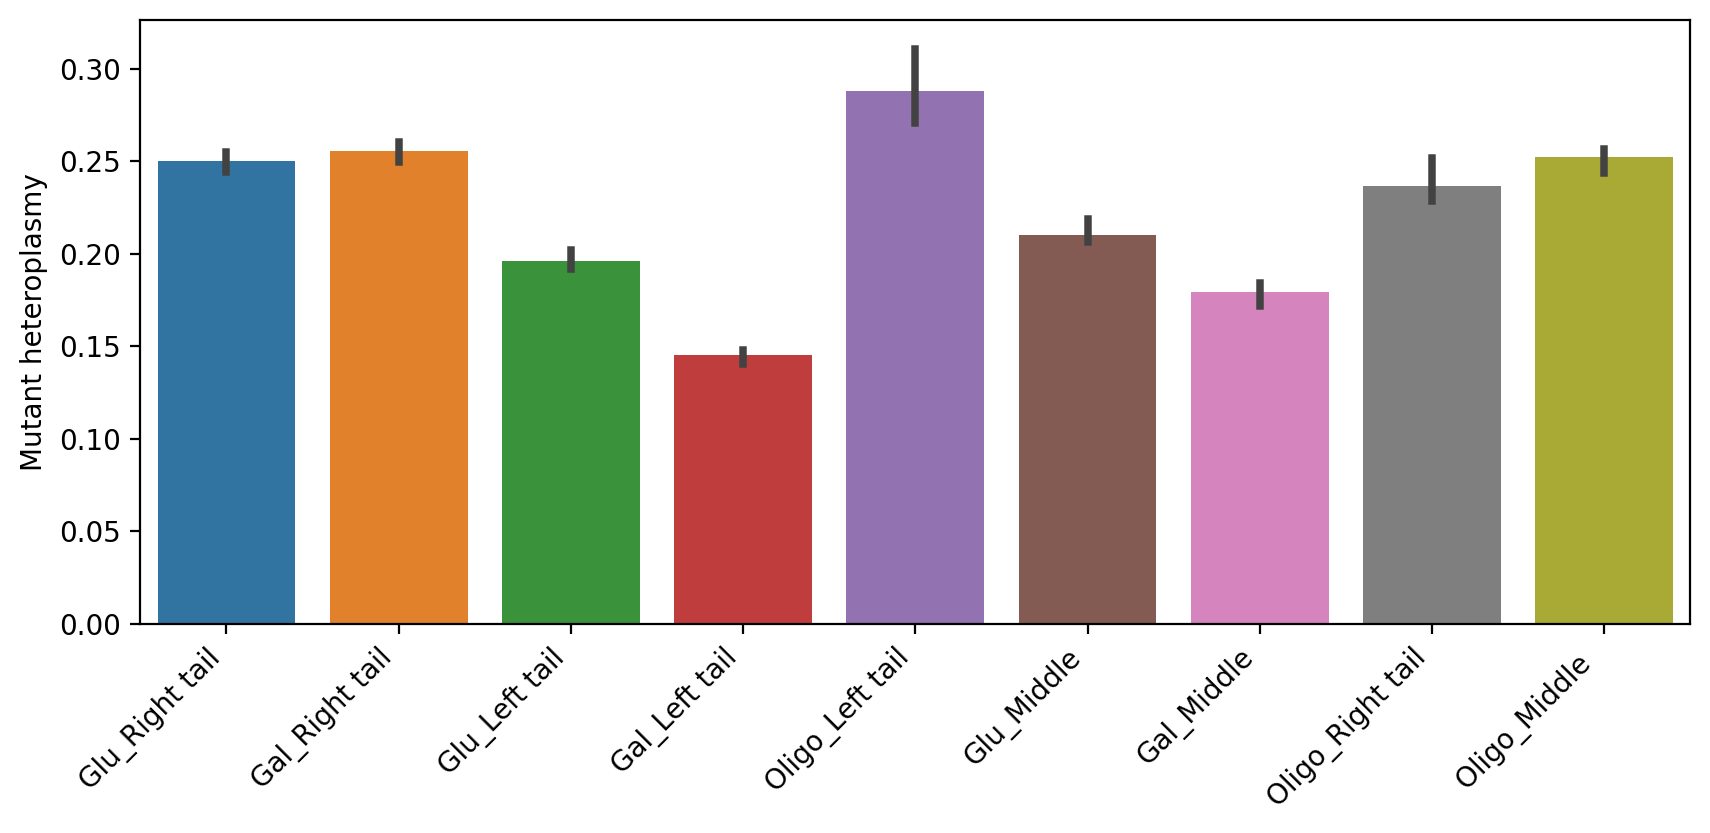

In [17]:
fig, axes = pyplot.subplots(nrows=1, ncols=1, figsize=(10,4))
seaborn.barplot(data=sample_info, x='sample_name_norep', y='mut_het', ax=axes)
axes.set_xticklabels(axes.get_xticklabels(), ha='right', rotation=45)
axes.set_xlabel('')
axes.set_ylabel('Mutant heteroplasmy')
fig.show()

In [18]:
sample_info.to_csv('./bulk_celltrace.count_data.csv', index=False)